# Segmenting Lungs from Chest X-Rays using ResUnet Architecture (Pytorch)
> In this blog, I will demonstrate how to deal with segmentation problems in 2D Medical images (Chest X-rays). You will get familiar with various preprocessing+post processing, data augmentation techniques, tips, and dead-ends in 2D Medical images segmentation.    <br />Keywords- Medical Imaging, Deep Learning, Pytorch, MONAI, Chest X-Ray, Segmentation, UNet, ResUnet, Lung segmentaion, tutorial, MICCAI

- toc: true 
- badges: true
- comments: true
- categories: [tutorial]
- image: images/blog_4.png
- author: Akansh Maurya

# About

**Knowledge is not the power, implementation is power**. ~ **Garrison Wynn.** 

You have completed a course in Machine Learning and Deep learning, and you are excited to apply your newly earned AI wisdom to the field of Healthcare and Medical images, but the only obstacle is that you don't know which tools you should use? How should you approach the problem and write the code? And the bigger question **How should I move from theory to practice?**

If these are your worries, then you are at the right place. This blog is all about giving you the right tools to implement your knowledge and feel **powerful**. In this blog, we will learn how to perform segmentation in 2D images. We will be working with Chest X-rays to segment lungs but this blog is applicable for other datasets too. We will be using awesome python libraries Pytorch. We will be learning Pre/Post-processing techniques, Data Augmentation methods. We will also review the concepts of Unet, Dice Metric and Dice loss.



As this blog is written using [fastpages](https://github.com/fastai/fastpages), you can run this whole tutorial and associated code as a Jupyter notebook.

**Isn't that exciting?** 

Lets get Started!

## What is Segmentation?

Many of you must be already familiar with what segmentation is? In case you are new, a one-line definition of segmentation could be that it is **pixel-wise classification**. In segmentation, we try to classify each and every pixel of the image into one or the other class. 

![](./my_icons/computer-vision-problems-1.png "Credit: https://blog.roboflow.com")

In our case we have to classify all the pixels into two classes:

- 0: Background
- 1: Lungs

## Why Segmentation? 

Medical Image segmentation has become an essential task in medical image analysis. In the paper “**Why rankings of biomedical image analysis competitions should be interpreted with care”,** a study on 150 biomedical image analysis challenges was performed. It showed that segmentation is the most popular problem.

![](my_icons/why_segmentation.png "Credit:https://www.nature.com/articles/s41467-018-07619-7")

The possible reason is that the other problems are less challenging, or the segmentation has a more widespread use case than others. Some applications of segmentation are as follows:

- Automatic measurement of organs.
- Cell counting
- Simulations based on the extracted boundary information

# Dataset: Montgomery-County-CXR-Set

We will be using openly available Montgomery-County-CXR Dataset[1][2]. The standard digital image database for Tuberculosis is created by the National Library of Medicine in collaboration with the Department of Health and Human Services, Montgomery County, Maryland, USA. The set contains data from X-­‐rays collected under Montgomery County`s Tuberculosis screening program.
In the dataset we have annotations made by radiologist segmenting the lungs. We will be only caring about the segmentaion of lungs but not about the classificaiton of Tuberculosis. 


## Getting the Dataset

The dataset is available on [NIH Website](https://data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Montgomery-County-CXR-Set/MontgomerySet/index.html). It has a size of around 700 MBs. All the CXR are either .jpeg, .jpg, .png files.

In [ ]:
#Data Downlaod
!wget -r "https://data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Montgomery-County-CXR-Set/MontgomerySet/index.html"

Always before jumping to building models, our first task should be understanding the datasets. We need to at least answer the following questions ourselves.

- What is the extension(.npy, .jpg, .jpeg, .dcm) of the files?
- How many training/validation files are present?
- How many classes are present?
- Is the dataset imbalanced?
- If the dataset is images, what are their dimensions? Are these dimensions uniform across all the files?
- etc.

As I mentioned these are the bare minimum questions that one should ask while performing Elementary Data Analysis(EDA). This helps in better preparation of our pipeline from data augmentation, and model selection to post-processing.


## Elementary Data Analysis (EDA) and Pre-Processing

In [1]:
#hide
import pandas as pd
import numpy as np
import os 
import glob
import matplotlib.pyplot as plt
from PIL import Image

In the dataset, along with the CXR images, we have masks of lungs. These masks are split into two images representing left lung lobe and right lung lobe. 

In [3]:
img_path = "./data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Montgomery-County-CXR-Set/MontgomerySet/CXR_png"
img_mask_left = "./data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Montgomery-County-CXR-Set/MontgomerySet/ManualMask/leftMask"
img_mask_right = "./data.lhncbc.nlm.nih.gov/public/Tuberculosis-Chest-X-ray-Datasets/Montgomery-County-CXR-Set/MontgomerySet/ManualMask/rightMask"

In [4]:
print(f"Number of files in img_path:{len([i for i in os.listdir(img_path) if i.endswith('.png')])}")
print(f"Number of files in img_mask_left: {len([i for i in os.listdir(img_mask_left) if i.endswith('.png')])}")
print(f"Number of files in img_mask_right: {len([i for i in os.listdir(img_mask_right) if i.endswith('.png')])}")

Number of files in img_path:138
Number of files in img_mask_left: 138
Number of files in img_mask_right: 138


As expected the number of CXR images and corresponding lung mask(left and right lobe) are same in number. As 138 is small number of images, we will be **aggressively** performing data augmentation to increase the datapoint. 

But before that we need to pre-process these mask into one image file. It will be a very easy operation, we just need to add both the image mask of same CXR.

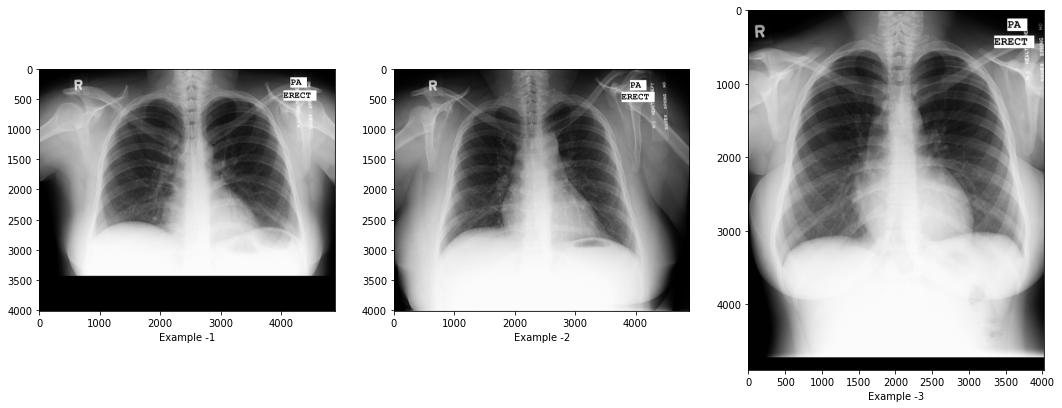

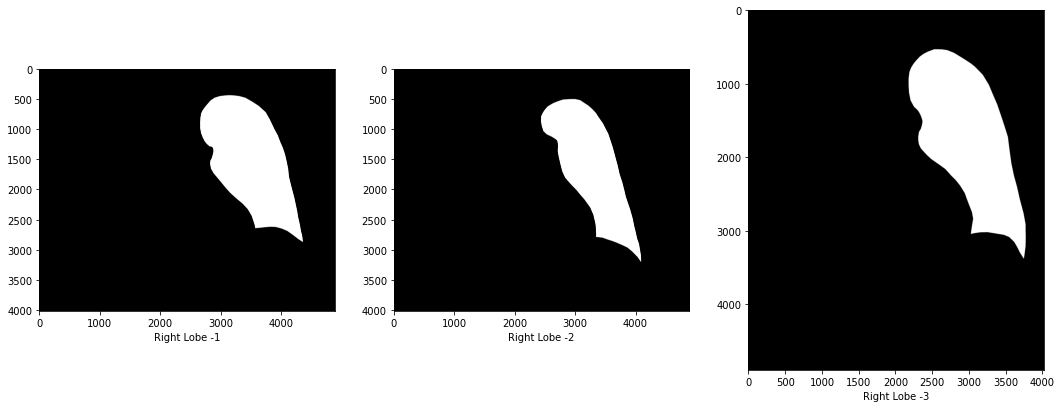

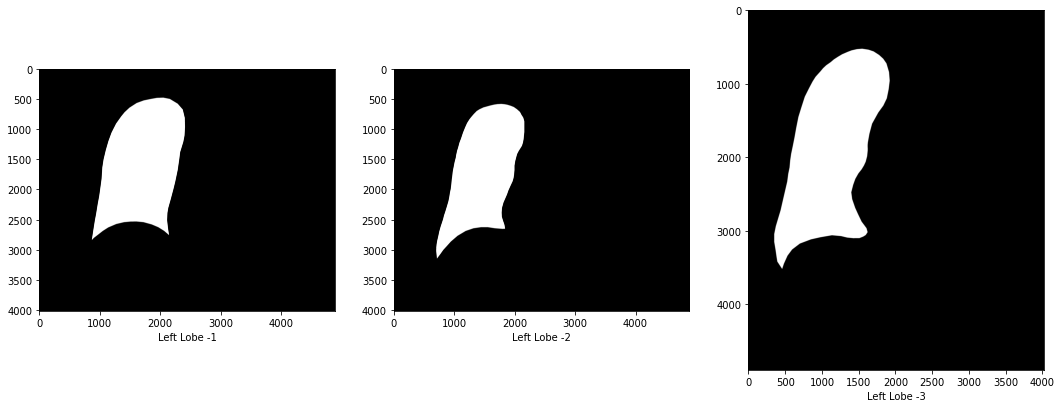

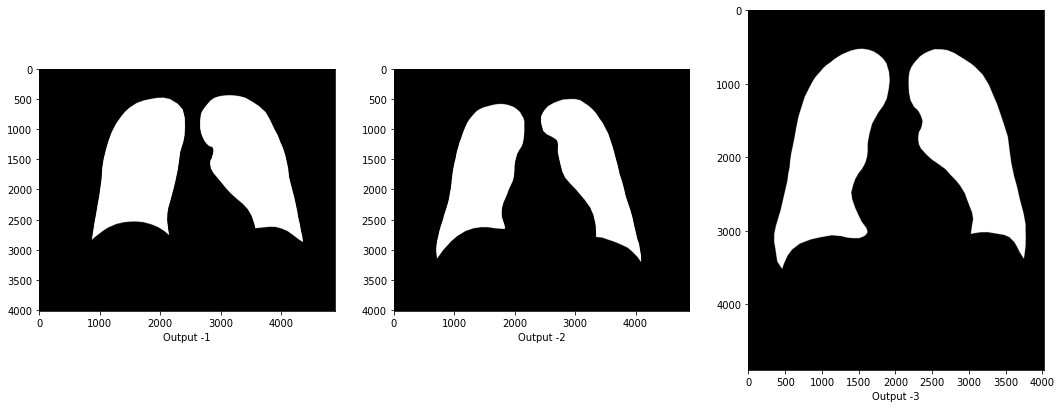

In [13]:
#hide_input
img_names = [i for i in os.listdir(img_path) if i.endswith('.png')]
left_mask = [i for i in os.listdir(img_mask_left) if i.endswith('.png')]
right_mask = [i for i in os.listdir(img_mask_right) if i.endswith('.png')]
img_names.sort()
left_mask.sort()
right_mask.sort()

plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread(os.path.join(img_path,img_names[0])), cmap = 'gray')
plt.xlabel('Example -1')
plt.subplot(1,3,2)
plt.imshow(plt.imread(os.path.join(img_path,img_names[1])), cmap = 'gray')
plt.xlabel('Example -2')
plt.subplot(1,3,3)
plt.imshow(plt.imread(os.path.join(img_path,img_names[2])), cmap = 'gray')
plt.xlabel('Example -3');
plt.show()

plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread(os.path.join(img_mask_right,img_names[0])), cmap = 'gray')
plt.xlabel('Right Lobe -1')
plt.subplot(1,3,2)
plt.imshow(plt.imread(os.path.join(img_mask_right,img_names[1])), cmap = 'gray')
plt.xlabel('Right Lobe -2')
plt.subplot(1,3,3)
plt.imshow(plt.imread(os.path.join(img_mask_right,img_names[2])), cmap = 'gray')
plt.xlabel('Right Lobe -3');
plt.show()

plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread(os.path.join(img_mask_left,img_names[0])), cmap = 'gray')
plt.xlabel('Left Lobe -1')
plt.subplot(1,3,2)
plt.imshow(plt.imread(os.path.join(img_mask_left,img_names[1])), cmap = 'gray')
plt.xlabel('Left Lobe -2')
plt.subplot(1,3,3)
plt.imshow(plt.imread(os.path.join(img_mask_left,img_names[2])), cmap = 'gray')
plt.xlabel('Left Lobe -3');
plt.show()

#Output
plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread(os.path.join(img_mask_left,img_names[0])) + plt.imread(os.path.join(img_mask_right,img_names[0])), cmap = 'gray')
plt.xlabel('Output -1')
plt.subplot(1,3,2)
plt.imshow(plt.imread(os.path.join(img_mask_left,img_names[1])) + plt.imread(os.path.join(img_mask_right,img_names[1])), cmap = 'gray')
plt.xlabel('Output -2')
plt.subplot(1,3,3)
plt.imshow(plt.imread(os.path.join(img_mask_left,img_names[2])) + plt.imread(os.path.join(img_mask_right,img_names[2])), cmap = 'gray')
plt.xlabel('Output -3');
plt.show()


As the image size varies we will also add resizing image to **(224,224)** as final pre-processing step.

In [18]:
#hide
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from tqdm.auto import tqdm

Resizing function is defined as follow.

In [19]:
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    return im

In [21]:
#hide
os.makedirs("./data/images/", exist_ok=True)
os.makedirs("./data/masks/", exist_ok=True)

output_images_path = "./data/images/"
output_mask_path = "./data/masks/"
for i in tqdm(img_names):
    orig = Image.open(os.path.join(img_path,i))
    im = orig.resize((224, 224), Image.LANCZOS)
    im.save(os.path.join(output_images_path)+i, 'PNG', quality= 95)

  0%|          | 0/138 [00:00<?, ?it/s]

In [22]:
#hide
for i in tqdm(img_names):
    orig_left = Image.open(os.path.join(img_mask_left,i))
    orig_right = Image.open(os.path.join(img_mask_right,i))
    mask = Image.fromarray(np.array(orig_left) + np.array(orig_right))
    im = mask.resize((224, 224), Image.LANCZOS)
    im.save(os.path.join(output_mask_path)+i, 'PNG', quality= 95)

  0%|          | 0/138 [00:00<?, ?it/s]

After pre-processing, CXR and their corresponding mask will look like as follow:

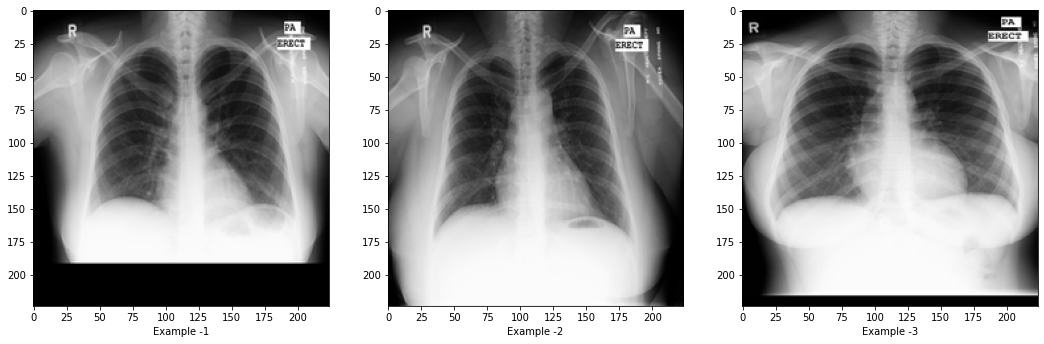

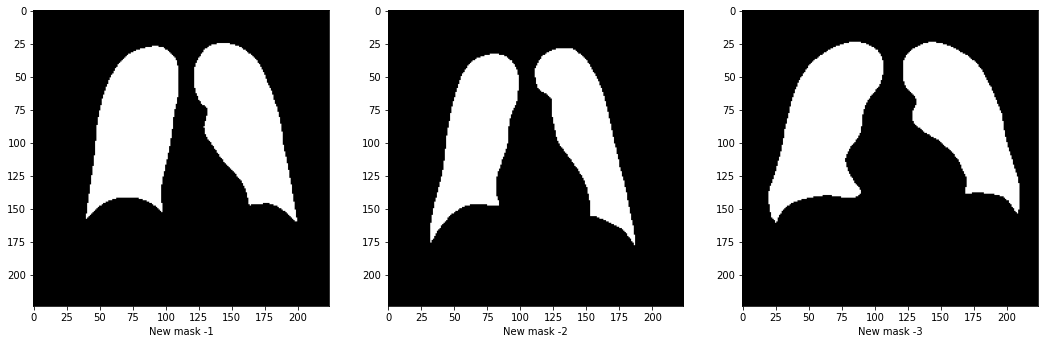

In [34]:
img_path = "./data/images/"
img_mask = "./data/masks/"

plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread(os.path.join(img_path,img_names[0])), cmap = 'gray')
plt.xlabel('Example -1')
plt.subplot(1,3,2)
plt.imshow(plt.imread(os.path.join(img_path,img_names[1])), cmap = 'gray')
plt.xlabel('Example -2')
plt.subplot(1,3,3)
plt.imshow(plt.imread(os.path.join(img_path,img_names[2])), cmap = 'gray')
plt.xlabel('Example -3');
plt.show()

plt.figure(figsize = (18,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread(os.path.join(img_mask,img_names[0])), cmap = 'gray')
plt.xlabel('New mask -1')
plt.subplot(1,3,2)
plt.imshow(plt.imread(os.path.join(img_mask,img_names[1])), cmap = 'gray')
plt.xlabel('New mask -2')
plt.subplot(1,3,3)
plt.imshow(plt.imread(os.path.join(img_mask,img_names[2])), cmap = 'gray')
plt.xlabel('New mask -3');
plt.show()


Congratulations! You made it! Now you understand how to read most popular medical imaging formats(DICOM and NIfTI). By following this notebook you also learned how to manipulate and visualize these images. 

# References

- [1] Candemir S, Jaeger S, Musco J, Xue Z, Karargyris A, Antani SK, Thoma GR, Palaniappan K. Lung
    segmentation in chest radiographs using anatomical atlases with nonrigid registration. IEEE
    Trans Med Imaging. 2014 Feb;33(2):577-­‐90. doi: 10.1109/TMI.2013.2290491. PMID: 24239990
- [2] Jaeger S, Karargyris A, Candemir S, Folio L, Siegelman J, Callaghan FM, Xue Z, Palaniappan K,
    Singh RK, Antani SK. Automatic tuberculosis screening using chest radiographs. IEEE Trans Med
    Imaging. 2014 Feb;33(2):233-­‐45. doi: 10.1109/TMI.2013.2284099. PMID: 24108713
- pyDicom: https://pydicom.github.io/
- Github original Code: https://github.com/akansh12/lung-seg/tree/main/notebook


# About Me:
I am Akansh maurya, working as a post-bacc at Robert Bosch Center of Data Science and AI, Indian Institute of Technology(IIT), Madras. 

> My page: https://akansh12.github.io/


> <a href="https://twitter.com/akansh_maurya?ref_src=twsrc%5Etfw" class="twitter-follow-button" data-show-count="false">Follow @akansh_maurya</a><script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Consider joining our telegram channel for discussion, tutorials, talks and, new research in Deep learning and Medical Imaging.

> <script async src="https://telegram.org/js/telegram-widget.js?19" data-telegram-post="karma_DL_in_medical_imaging/3" data-width="100%"></script>